<a href="https://colab.research.google.com/github/RogerReateguiUTEC/TareasIAFundamentals/blob/main/Practica3_GeneticAlgorithm_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from matplotlib import pyplot as plt
import random

# 1. DEFINICIÓN DE LAS FUNCIONES

In [14]:
def plot_tsp(cities, route):
    x = [node[0] for node in cities]
    y = [node[1] for node in cities]

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color='blue', zorder=2)  #Graficando los nodos

    # for i in range(len(cities)):
    #     plt.text(cities[i][0], cities[i][1], f'({round(cities[i][0],3)}, {round(cities[i][1],3)})', fontsize=8) #etiquetas en cada coordenada de ciudad


    for i in range(len(route) - 1):
        node1 = route[i]
        node2 = route[i + 1]
        plt.plot([cities[node1][0], cities[node2][0]], [cities[node1][1], cities[node2][1]], color='red', zorder=1)  # Plot route

    # Connect the last node to the first node to form a loop
    #node1 = route[-1]
    #node2 = route[0]
    #plt.plot([cities[node1][0], cities[node2][0]], [cities[node1][1], cities[node2][1]], color='red', zorder=1)  # Plot route

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('TSP Nodes and Route')
    plt.grid(True)
    plt.show()

In [12]:
def fitness(solution):
  distance = 0
  for i in range(len(solution)-1):
    distance += distances[solution[i]][solution[i+1]]
  return distance

In [5]:
def create_initial_population(pop_size, num_cities):
  population = [] #vector de soluciones
  for i in range(pop_size):
    # crear solucion
    individual = list(np.random.permutation(num_cities)) #genotipos
    population.append(individual)

  return population

In [6]:
def roulete_wheel_selection_minimization(population, all_fitness):
    max_fitness = max(all_fitness)
    inverted_fitness = [max_fitness - f for f in all_fitness]  # invert fitness
    total_fitness = sum(inverted_fitness)
    selection_probs = [f / total_fitness for f in inverted_fitness]
    return population[np.random.choice(len(population), p=selection_probs)]

In [7]:
def fill_child(child, parent, end):
    size = len(parent)
    current_pos = (end + 1) % size
    for gene in parent:
        if gene not in child:
            child[current_pos] = gene
            current_pos = (current_pos + 1) % size

def ordered_crossover(parent1, parent2):
  size = len(parent1)
  child1 = [-1]*size
  child2 = [-1]*size

  start, end = sorted( random.sample(range(size), 2 ))

  child1[start:end+1] = parent2[start:end+1]
  child2[start:end+1] = parent1[start:end+1]

  fill_child(child1, parent1, end)
  fill_child(child2, parent2, end)

  return child1, child2

In [8]:
def swap_mutate(individual):
  i, j = np.random.choice(len(individual), 2, replace=False) # two random indices
  new_individual = individual.copy()
  new_individual[i], new_individual[j] = individual[j], individual[i]
  return new_individual

In [9]:
def select_elite(population, all_fitness, elite_size):   # selecciona los que tengan el mejor fitness
  elite_indices = np.argsort(all_fitness)[:elite_size]
  return np.array(population)[elite_indices], elite_indices

In [10]:
history = []

def genetic_algorithm_experiment1(distance_matrix, mutation_rate, generations):
  num_cities = distance_matrix.shape[0]

  #1. INICIALIZACION DE LA POBLACION (RANDOM):
  population = create_initial_population(pop_size, N) #pop_size = 100; N = 50. [[45,15,...n50],[42,26,...n50]...[m100]] #esto es como el orden en que el TSP irá a cada ciudad (primero a la 45, luego a la 15, etc.)

  #Hallamos el fitness de cada solución en la población (lista de distancias totales)
  all_fitness = [ fitness(sol) for sol in population ]

  for generation in range(generations):
    new_population = []

    #Se guardan los mejores de la antigua población
    selected_elite, indices = select_elite(population, all_fitness, elite_size)
    new_population.extend( selected_elite )

    while len(new_population) < pop_size:
      #2. SELECCION: Escogemos una muestra de la población por distintos métodos
      parent1 = roulete_wheel_selection_minimization(population, all_fitness)
      parent2 = roulete_wheel_selection_minimization(population, all_fitness)

      #3. CROSSOVER:
      child1, child2 = ordered_crossover(parent1, parent2)

      #4.MUTATION:
      if random.random() < mutation_rate:
        child1 = swap_mutate(child1)

      if random.random() < mutation_rate:
        child2 = swap_mutate(child2)

      #5.SUBSTITUTION:
      new_population.extend([child1, child2])

    population = new_population[:pop_size]
    all_fitness = [ fitness(sol) for sol in population ]


    if generation % 50 == 0:
      print(f"Generation {generation} | Best distance: {min(all_fitness)}")
      history.append([generation, min(all_fitness)])


  best_route_index = np.argmin(all_fitness)
  best_route = population[best_route_index]
  best_distance = all_fitness[best_route_index]

  print(f"Final best distance: {best_distance}")
  return best_route, best_distance

# 2. EJECUCIÓN DEL PROBLEMA

Generation 0 | Best distance: 46.434406523346674
Generation 50 | Best distance: 31.64681404446973
Generation 100 | Best distance: 28.088374247143587
Generation 150 | Best distance: 25.27646416104563
Generation 200 | Best distance: 22.098467324122986
Generation 250 | Best distance: 19.79321662511765
Generation 300 | Best distance: 18.563071851824233
Generation 350 | Best distance: 18.31371114500811
Generation 400 | Best distance: 17.573946327684176
Generation 450 | Best distance: 17.30126505876857
Generation 500 | Best distance: 16.943339795717897
Generation 550 | Best distance: 16.383692333414984
Generation 600 | Best distance: 15.771779544508144
Generation 650 | Best distance: 15.21933090667385
Generation 700 | Best distance: 14.570206096965475
Generation 750 | Best distance: 14.30983773091537
Generation 800 | Best distance: 14.136438511310569
Generation 850 | Best distance: 14.078328217247996
Generation 900 | Best distance: 13.995624854294643
Generation 950 | Best distance: 13.895456

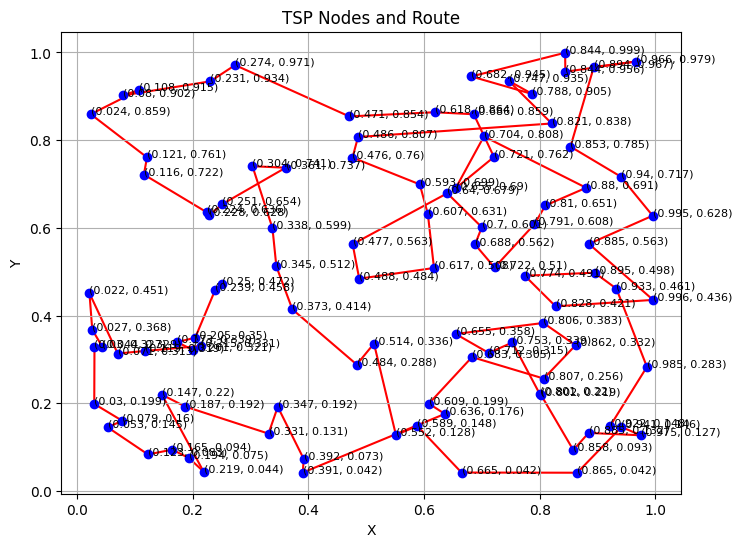

In [13]:
# HYPERPARAMETROS:

pop_size = 100 #cantidad de soluciones (población o genomas)
N = 100 #cantidad de ciudades
elite_size = 10 #elite de soluciones que se mantiene en cada generación
mutation_rate = 0.01 #probabilidad para la mutación de cada hijo
generations = 5000 #cantidad de generaciones o iteraciones


cities = np.random.rand(N, 2) #matriz de coordenadas para cada ciudad
distances = squareform(pdist(cities, 'euclidean'))

best_route, best_distance = genetic_algorithm_experiment1(distances, mutation_rate, generations)
plot_tsp(cities, best_route)